In [1]:
import datetime as dt
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from collections import Counter
import matplotlib.ticker as plticker
import matplotlib.colors as colors
import numpy as np
import geopandas as gpd
import pandas as pd
from epiweeks import Week,Year
import matplotlib as mpl
from shapely.geometry import Point
import seaborn as sns

from pandas.plotting._matplotlib.tools import flatten_axes as _flatten
from pandas.plotting._matplotlib.tools import create_subplots as _subplots


from scipy.stats import pearsonr
from scipy.stats import norm
import uncertainties.unumpy as unp

from patsy import dmatrices
import statsmodels.api as sm

import joypy

font = {'family' : 'Helvetica',
'weight' : 'bold',
'size' : 18}
mpl.rcParams.update({"svg.fonttype": 'none', 'text.usetex': False})

pd.set_option('display.max_rows', 500)

state_dict = {"NY":"New York", "CT":"Connecticut", "MA":"Massachusetts", "RI":"Rhode Island", "NH":"New Hampshire"}


In [2]:
hex_codes = [
    "#618669",
    "#4E5E48",
    "#F1C081",
    "#C08A46",
    "#A83B17",
    "#862E19",
    "#62270C"
]

state_colours = {"NY_light":"#618669", "NY_dark":"#4E5E48", "New_York_light": "#618669", "New_York_dark": "#4E5E48",
                 "MA_light":"#F1C081", "MA_dark":"#C08A46", "Massachusetts_light":"#F1C081", "Massachusetts_dark":"#C08A46",
                "CT_light":"#A83B17", "CT_dark":"#862E19", "Connecticut_light":"#A83B17", "Connecticut_dark":"#862E19",
                "other":"#62270C", "Other":"#62270C"}

simplified_colours = {"NY":"#4E5E48", "MA":"#C08A46", "CT":"#862E19"}


col_pal = sns.color_palette(hex_codes)
col_pal

[(0.3803921568627451, 0.5254901960784314, 0.4117647058823529),
 (0.3058823529411765, 0.3686274509803922, 0.2823529411764706),
 (0.9450980392156862, 0.7529411764705882, 0.5058823529411764),
 (0.7529411764705882, 0.5411764705882353, 0.27450980392156865),
 (0.6588235294117647, 0.23137254901960785, 0.09019607843137255),
 (0.5254901960784314, 0.1803921568627451, 0.09803921568627451),
 (0.3843137254901961, 0.15294117647058825, 0.047058823529411764)]

In [3]:
all_years = []
for i in range(2003,2020):
    all_years.append(i)

In [4]:

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(len(x)-3)
    z = norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [5]:
def get_correlations(x,y,name):

    corr,p, lo, hi = pearsonr_ci(x,y)
    print(name)
    print(f'correlation = {corr}, p-value = {p}, CI= {lo} to {hi}')

In [6]:
def get_state_level_reg(state, overall_df, against, expr):
    
    df = overall_df.loc[overall_df['state'] == state]
    df = df.sort_values(by=against)
    
    y,x = dmatrices(expr, df, return_type='dataframe')
    poisson_results = sm.GLM(y,x, family=sm.families.Poisson()).fit()
    
    predictions = poisson_results.get_prediction(x)
    sum_frame = predictions.summary_frame()
    predicted_counts = sum_frame['mean']
    lower = sum_frame['mean_ci_lower']
    upper = sum_frame['mean_ci_upper']
    
    return df[against], predicted_counts, lower, upper

## get case data

In [6]:
states = ["NY", "CT", "MA"]
case_dict = defaultdict(dict)

human_case_csv = ""
horse_case_csv = ""

with open(human_case_csv) as f:
    data = csv.DictReader(f)
    print(data.fieldnames)
    for l in data:
        if l['state'] in states:
            year = int(l['year'])
            if year >= 2003 and year < 2020:
                if year in case_dict[l['state']]:
                    case_dict[l['state']][year] += int(l['count'])
                else:
                    case_dict[l['state']][year] = int(l['count'])
        
with open(horse_case_csv) as f:
    data = csv.DictReader(f)
    print(data.fieldnames)
    for l in data:
        if l['species'] == "Equine":
            if l['state'] in states:
                year = int(l['year'])
                if year >= 2003 and year < 2020:
                    if year in case_dict[l['state']]:
                        case_dict[l['state']][year] += 1
                    else:
                        case_dict[l['state']][year] = 1

['state', 'year', 'month', 'count']
['year', 'state', 'county', 'week', 'onsetdate', 'species', 'count']


In [8]:
infection_dict = defaultdict(dict)

ct_prevalence = ""
ma_prevalence = ""
ny_prevalence = ""

with open(ct_prevalence) as f:
    data = csv.DictReader(f)
    for l in data:
        if int(l['year']) >= 2003:
            infection_dict["CT"][int(l['year'])] = float(l['prevalence'])
            
with open(ny_prevalence) as f:
    data = csv.DictReader(f)
    for l in data:
        if int(l['year']) >=2003:
            infection_dict["NY"][int(l['year'])] = float(l['prevalence'])
            
with open(ma_prevalence) as f:
    data = csv.DictReader(f)
    for l in data:
        if int(l['year']) >=2003:
            infection_dict["MA"][int(l['year'])] = float(l['prevalence'])

In [9]:
for state, years in infection_dict.items():
    for year in years:
        if year not in case_dict[state]:
            case_dict[state][year]=0

## Cases against infection rates (all three states)

In [10]:
x = []
y = []
states = []

x_2019 = []
y_2019 = []
color_2019 = []

df_dict = defaultdict(list)

for state, year_dict in case_dict.items():
    for year, case in year_dict.items():
        y.append(case)
        x.append(infection_dict[state][year])
        states.append(state_colours[f'{state}_dark'])
        
        df_dict["cases"].append(case)
        df_dict["infection_rate"].append(infection_dict[state][year])
        df_dict["state"].append(state)
        df_dict["colours"].append(state_colours[f'{state}_dark'])
        
        if year == 2019:
            y_2019.append(case)
            x_2019.append(infection_dict[state][year])
            color_2019.append(state_colours[f'{state}_dark'])
            
df = pd.DataFrame(df_dict)
df = df.sort_values(by="infection_rate")

In [11]:
expr = """cases ~ infection_rate"""

y,x = dmatrices(expr, df, return_type='dataframe')
poisson_results = sm.GLM(y,x, family=sm.families.Poisson()).fit()

print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  cases   No. Observations:                   51
Model:                            GLM   Df Residuals:                       49
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -154.01
Date:                Thu, 15 Dec 2022   Deviance:                       204.58
Time:                        11:59:44   Pearson chi2:                     205.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8471
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4028      0.134      3.

In [12]:
predictions = poisson_results.get_prediction(x)
sum_frame = predictions.summary_frame()
predicted_counts = sum_frame['mean']
lower = sum_frame['mean_ci_lower']
upper = sum_frame['mean_ci_upper']

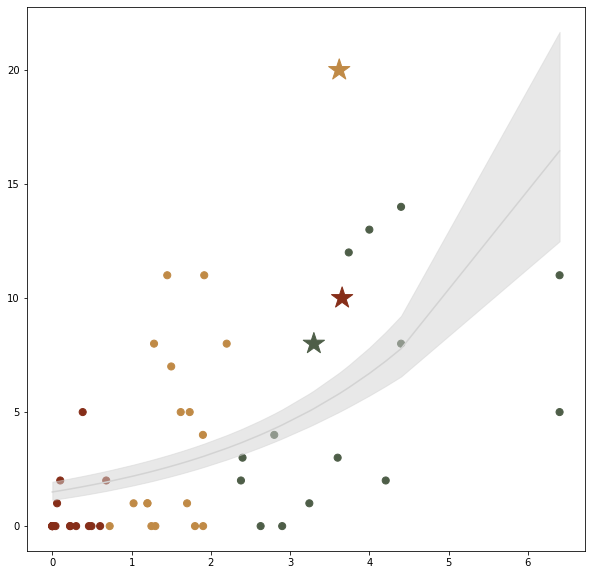

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.scatter(df['infection_rate'],df['cases'], color=states, s=50)
plt.plot(df['infection_rate'],predicted_counts, color="lightgrey")
plt.scatter(x_2019, y_2019, marker="*", s=500, color=color_2019)
plt.fill_between(df['infection_rate'],lower, upper, alpha=0.5, color="lightgrey")



In [14]:
#args have changed so this needs updating before rerunning
expr = expr = """cases ~ infection_rate"""
ct_x, ct_y, ct_lower, ct_upper = get_state_level_reg("CT", df, "infection_rate", expr)
ma_x, ma_y, ma_lower, ma_upper = get_state_level_reg("MA", df, "infection_rate", expr)
ny_x, ny_y, ny_lower, ny_upper = get_state_level_reg("NY", df, "infection_rate", expr)

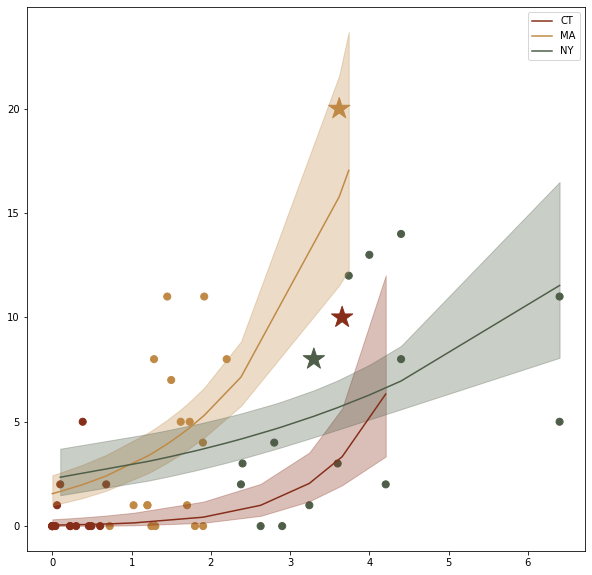

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.scatter(df['infection_rate'],df['cases'], color=states, s=50)
plt.scatter(x_2019, y_2019, marker="*", s=500, color=color_2019)

plt.plot(ct_x,ct_y, color=state_colours["CT_dark"], label="CT")
plt.fill_between(ct_x,ct_lower, ct_upper, alpha=0.3, color=state_colours["CT_dark"])

plt.plot(ma_x,ma_y, color=state_colours["MA_dark"], label="MA")
plt.fill_between(ma_x,ma_lower, ma_upper, alpha=0.3, color=state_colours["MA_dark"])

plt.plot(ny_x,ny_y, color=state_colours["NY_dark"], label="NY")
plt.fill_between(ny_x,ny_lower, ny_upper, alpha=0.3, color=state_colours["NY_dark"])

ax.legend()



## Cases against positive mosquito pools (all thre)

In [294]:


ct_pools = {}
with open("../../data/mosquito_data/CT_mosquito.csv") as f:
    data = csv.DictReader(f)
    for l in data:
        if l['Species'] == "Culiseta melanura":
            year = dt.datetime.strptime(l['Date'], "%Y-%m-%d").year
            if year in ct_pools:
                ct_pools[year] += 1
            else:
                ct_pools[year] = 1
                
ma_pools = {}
with open("../../data/mosquito_data/MA_mosquito.csv") as f:
    data = csv.DictReader(f)
    for l in data:
        year = dt.datetime.strptime(l['Collection Date'], "%Y-%m-%d").year
        if year in ma_pools:
            ma_pools[year] += 1
        else:
            ma_pools[year] = 1
            
ny_pools = {}
with open("../../data/mosquito_data/NY_mosquito.csv") as f:
    data = csv.DictReader(f)
    years = data.fieldnames
    for i in years:
        if i != "county":
            ny_pools[int(i)] = 0
    for l in data:
        for i in years:
            if i != "county":
                ny_pools[int(i)] += int(l[i])
    
pools = {"CT":ct_pools, "MA":ma_pools, "NY":ny_pools}
for state, pool_dict in pools.items():
    for i in all_years:
        if i not in pool_dict:
            pool_dict[i] = 0
            

In [302]:
df_dict = defaultdict(list)
x_2019 = []
y_2019 = []
color_2019 = []

for state, c_dict in case_dict.items():

    for year, count in c_dict.items():
        df_dict["state"].append(state)
        df_dict["cases"].append(count)
        df_dict["pos_pools"].append(pools[state][year])
        df_dict["colours"].append(state_colours[f'{state}_dark'])
        
        if year == 2019:
            y_2019.append(count)
            x_2019.append(pools[state][year])
            color_2019.append(state_colours[f'{state}_dark'])
        
df = pd.DataFrame(df_dict)
df = df.sort_values(by="pos_pools")

In [297]:
expr = """cases ~ pos_pools"""
against = "pos_pools"

y,x = dmatrices(expr, df, return_type='dataframe')
poisson_results = sm.GLM(y,x, family=sm.families.Poisson()).fit()

ct_x, ct_y, ct_lower, ct_upper = get_state_level_reg("CT", df, against, expr)
ma_x, ma_y, ma_lower, ma_upper = get_state_level_reg("MA", df, against, expr)
ny_x, ny_y, ny_lower, ny_upper = get_state_level_reg("NY", df, against, expr)

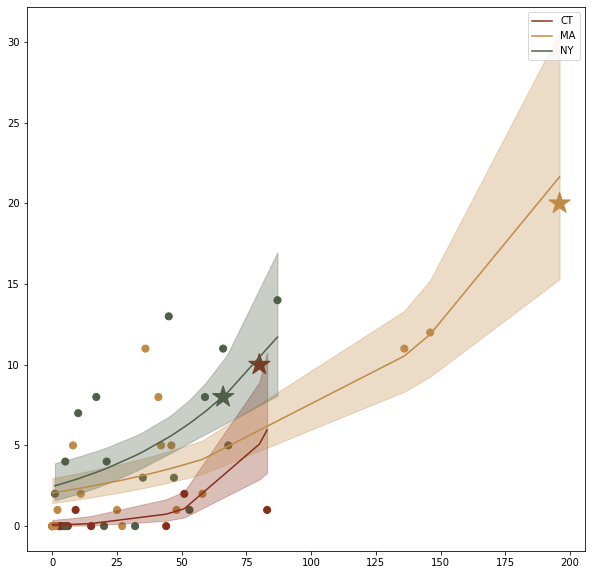

In [109]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.scatter(df['pos_pools'],df['cases'], color=df["colours"], s=50)
plt.scatter(x_2019, y_2019, marker="*", s=500, color=color_2019)

plt.plot(ct_x,ct_y, color=state_colours["CT_dark"], label="CT")
plt.fill_between(ct_x,ct_lower, ct_upper, alpha=0.3, color=state_colours["CT_dark"])

plt.plot(ma_x,ma_y, color=state_colours["MA_dark"], label="MA")
plt.fill_between(ma_x,ma_lower, ma_upper, alpha=0.3, color=state_colours["MA_dark"])

plt.plot(ny_x,ny_y, color=state_colours["NY_dark"], label="NY")
plt.fill_between(ny_x,ny_lower, ny_upper, alpha=0.3, color=state_colours["NY_dark"])

ax.legend()



In [303]:
predictions = poisson_results.get_prediction(x)
sum_frame = predictions.summary_frame()
predicted_counts = sum_frame['mean']
lower = sum_frame['mean_ci_lower']
upper = sum_frame['mean_ci_upper']

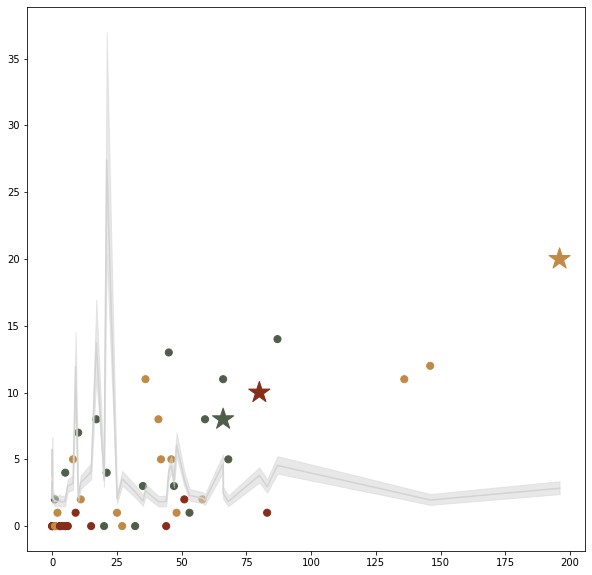

In [304]:
state_colour_list = []
for state in ["CT", "NY", "MA"]:
    state_colour_list.append(state_colours[f'{state}_dark'])


fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.scatter(df['pos_pools'],df['cases'], color=df['colours'], s=50)
plt.plot(df['pos_pools'],predicted_counts, color="lightgrey")
plt.scatter(x_2019, y_2019, marker="*", s=500, color=color_2019)
plt.fill_between(df['pos_pools'],lower, upper, alpha=0.5, color="lightgrey")



## Index P against abundance, IR, VI (just CT and MA)

In [13]:
ma_p = {}
ct_p = {}
with open("../../data/mosquito_data/combined_data.csv") as f:
    data = csv.DictReader(f)
    for l in data:
        if l['st_grp'] == "MA":
            ma_p[l['year']] = float(l['indexP'])
        elif l['st_grp'] == "CT":
            ct_p[l['year']] = float(l['indexP'])
            
ct_p = {k:v for k,v in sorted(ct_p.items(), key = lambda x:x[1])}
ct_p

{'2009': 0.002,
 '2006': 0.007,
 '2008': 0.007,
 '2003': 0.009,
 '2015': 0.01,
 '2004': 0.013,
 '2010': 0.019,
 '2013': 0.019,
 '2019': 0.022,
 '2012': 0.023,
 '2016': 0.024,
 '2020': 0.03,
 '2018': 0.037,
 '2014': 0.038,
 '2005': 0.044,
 '2011': 0.046,
 '2007': 0.079,
 '2017': 0.121}

In [7]:
mosquito_data = ""
def index_p_plots(state, colour, c_2019):

    index_p = []
    abun = []
    ir = []
    vi = []

    p_2019 = []
    abun_2019 = []
    ir_2019 = []
    vi_2019 = []
    with open(mosquito_data) as f:
        data = csv.DictReader(f)
        for l in data:
            if l['st_grp'] == state:
                if l['species'] != "NA":
                    if l['abundance'] == "NA":
                        abundance = 0
                    else:
                        abundance = float(l['abundance'])
                        
                    if l['vector_index'] == "NA":
                        vector = 0
                    else:
                        vector = float(l['vector_index'])
                    
                    
                    index_p.append(float(l['indexP']))
                    abun.append(abundance)
                    ir.append(float(l['pir']))
                    vi.append(vector)
                    
                    
                    if l['year'] == "2019":
                        p_2019.append(float(l['indexP']))
                        abun_2019.append(float(l['abundance']))
                        ir_2019.append(float(l['pir']))
                        vi_2019.append(float(l['vector_index']))
                        
    fig, ax = plt.subplots(1,3, figsize=(30,10))

    base_colour = colour
    base_size = 100
    size_2019 = 500

    sns.regplot(ax=ax[0], x=abun, y=index_p, scatter=False, color="darkgrey")
    sns.regplot(ax=ax[1], x=ir, y=index_p, scatter=False, color="darkgrey")
    sns.regplot(ax=ax[2], x=vi, y=index_p, scatter=False, color="darkgrey")

    ax[0].scatter(abun, index_p, color=base_colour, s=base_size, alpha=0.7)
    ax[1].scatter(ir, index_p, color=base_colour, s=base_size, alpha=0.7)
    ax[2].scatter(vi, index_p, color=base_colour, s=base_size, alpha=0.7)

    ax[0].scatter(abun_2019, p_2019, color=c_2019, marker="*", s=size_2019)
    ax[1].scatter(ir_2019, p_2019, color=c_2019, marker="*", s=size_2019)
    ax[2].scatter(vi_2019, p_2019, color=c_2019, marker="*", s=size_2019)


    ax[0].set_title("Abundance")
    ax[1].set_title("Infection rate")
    ax[2].set_title("Vector index")


    plt.show()
    
    get_correlations(abun, index_p, "abundance")
    get_correlations(ir, index_p, "infection rate")
    get_correlations(vi, index_p, "vector index")


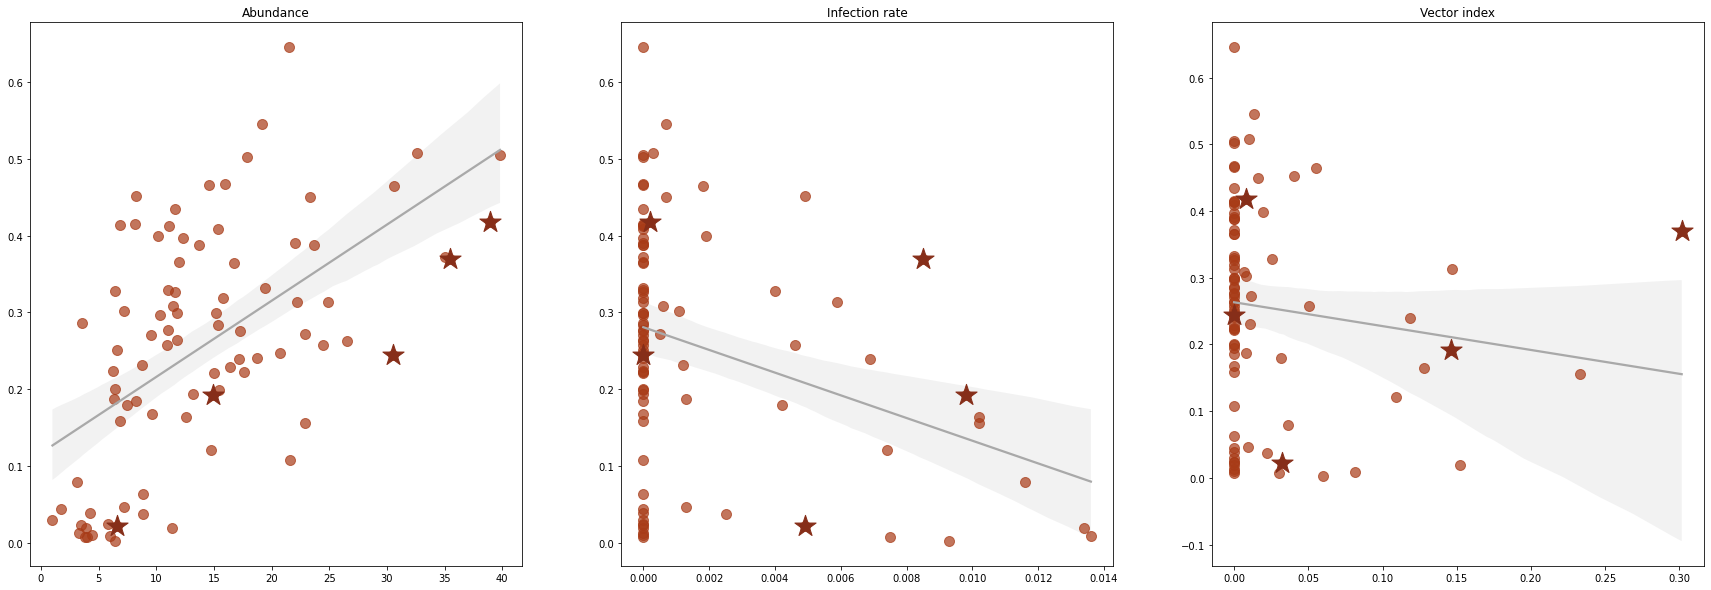

abundance
correlation = 0.5658406035770267, p-value = 9.201759275256996e-09, CI= 0.40431397404270863 to 0.6931383831241147
infection rate
correlation = -0.33111891264692755, p-value = 0.0016262685042599861, CI= -0.5055042975799626 to -0.13074377615489058
vector index
correlation = -0.12174484294486601, p-value = 0.2584984093597193, CI= -0.3229522947079238 to 0.08999207686698976


In [22]:
index_p_plots("CT", "#A83B17")

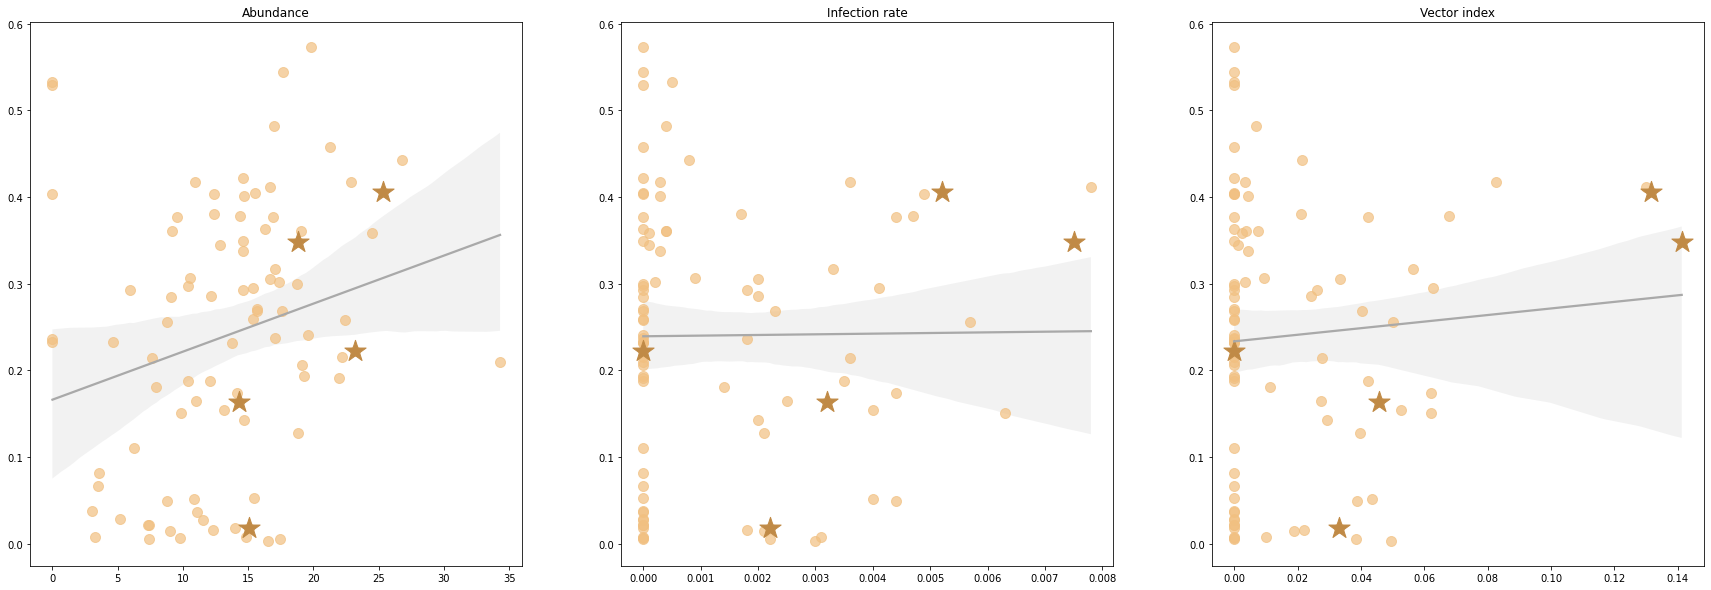

abundance
correlation = 0.23759842330398434, p-value = 0.02413686398589931, CI= 0.03208608899661084 to 0.42383494237898484
infection rate
correlation = 0.009705123313347823, p-value = 0.9276626370877796, CI= -0.19778350583118748 to 0.21636138549824432
vector index
correlation = 0.07525004305262158, p-value = 0.4808687710522654, CI= -0.1339281568157887 to 0.2780087762209078


In [50]:
index_p_plots("MA", "#F1C081", "#C08A46")

## index P, VI, IR, abundance over time (CT and MA)

In [19]:
month_dict = {"Jan": 1, "Feb":2, "Mar":3, "Apr":4, "May":5, "Jun":6, "Jul":7, "Aug":8, "Sep":9, "Oct":10,"Nov":11, "Dec":12}

index_p = defaultdict(dict)
abun = defaultdict(dict)
ir = defaultdict(dict)
vi = defaultdict(dict)

with open("../../data/mosquito_data/combined_data.csv") as f:
    data = csv.DictReader(f)
    print(data.fieldnames)
    for l in data:
        if l['st_grp'] == "MA":
            if l['species'] != "NA":
                
                year = float(l['year'])
                month = month_dict[l['month']]
                
                if l['abundance'] == "NA":
                    abundance = 0
                else:
                    abundance = float(l['abundance'])
                        
                if l['vector_index'] == "NA":
                    vector = 0
                else:
                    vector = float(l['vector_index'])

                    
                index_p[year][month] = (float(l['indexP']))
                abun[year][month] = (abundance)
                ir[year][month]=(float(l['pir']))
                vi[year][month] = float(vector)
                


['', 'st_grp', 'year', 'month', 'month_m', 'indexP', 'indexPlower', 'indexPupper', 'temp', 'humidity', 'precip', 'threshold_3', 'threshold_4', 'threshold_5', 'human', 'other', 'species', 'abundance', 'pir', 'pir_lci', 'pir_uci', 'vector_index', 'month_n', 'year_f', 'year_grp', 'all_cases', 'indexP_lag1', 'temp_lag1', 'vector_index_lag1', 'vector_index_lag2', 'eeev_detected']


In [20]:
df_dict = defaultdict(list)
months = [5,6,7,8,9,10]

for year in all_years:
    for month in months:
        df_dict["year"].append(year)
        df_dict["month"].append(month)
        
        if month in index_p[year]:
            df_dict["index_p"].append(index_p[year][month])
        else:
            df_dict["index_p"].append(0)
            
        if month in abun[year]:
            df_dict["abundance"].append(abun[year][month])
        else:
            df_dict["abundance"].append(0)
        
        if month in ir[year]:
            df_dict["infection_rate"].append(ir[year][month])
        else:
            df_dict["infection_rate"].append(0)
            
        if month in vi[year]:
            df_dict["vector_index"].append(vi[year][month])
        else:
            df_dict["vector_index"].append(0)
        
df= pd.DataFrame(df_dict)
df

,year,month,index_p,abundance,infection_rate,vector_index
0,2003,5,0.021,7.285714,0.0000,0.0000
1,2003,6,0.293,5.944635,0.0000,0.0000
2,2003,7,0.529,0.000000,0.0000,0.0000
3,2003,8,0.532,0.000000,0.0005,0.0000
4,2003,9,0.236,0.000000,0.0018,0.0000
5,2003,10,0.008,14.833333,0.0000,0.0000
6,2004,5,0.066,3.500000,0.0000,0.0000
7,2004,6,0.188,10.411886,0.0000,0.0000
8,2004,7,0.361,9.124269,0.0004,0.0036
9,2004,8,0.377,9.560532,0.0044,0.0421


In [21]:
df_dict = defaultdict(list)
months = [5,6,7,8,9,10]
count = 0

for month in months:
    df_dict["measure"].append("index_p")
    df_dict["measure"].append("abundance")
    df_dict["measure"].append("infection_rate")
    df_dict["measure"].append("vector_index")

for year in all_years:
    for month in months:
        count += 1
        if month in index_p[year]:
            df_dict[year].append(index_p[year][month])
        else:
            df_dict[year].append(0)
            
        if month in abun[year]:
            df_dict[year].append(abun[year][month])
        else:
            df_dict[year].append(0)
        
        if month in ir[year]:
            df_dict[year].append(ir[year][month])
        else:
            df_dict[year].append(0)
            
        if month in vi[year]:
            df_dict[year].append(vi[year][month])
        else:
            df_dict[year].append(0)

df= pd.DataFrame(df_dict)


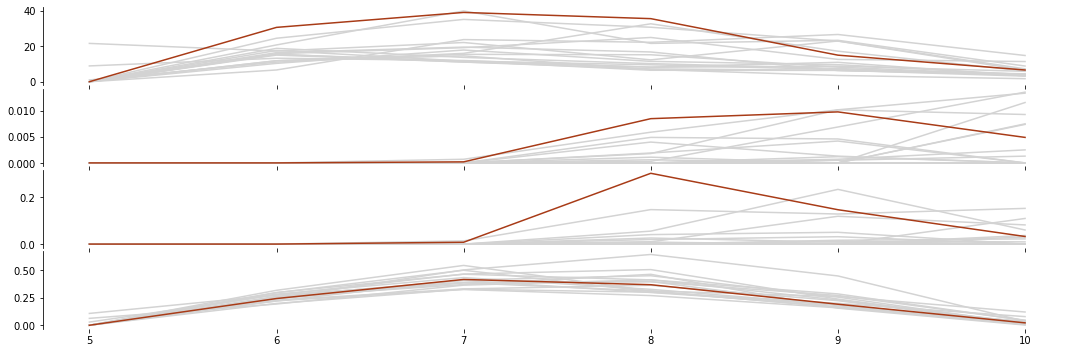

In [18]:
fig, ax = plt.subplots(4,1, figsize=(15,5), sharex=True)

for i,j in enumerate(["abundance", "infection_rate", "vector_index", "index_p"]):

    ax[i].patch.set_alpha(0)
    
    sub_df = df.loc[df["measure"] == j]

    for year in all_years:
        if year == 2019:
            colour="#A83B17"
        else:
            colour="lightgrey"

        ax[i].plot(months, sub_df[year], color=colour)
        

    for side in ['top', 'right', 'bottom']:
        ax[i].spines[side].set_visible(False)

overlap=0
h_pad = 5 + (- 5*(1 + overlap))
fig.tight_layout(h_pad=h_pad)



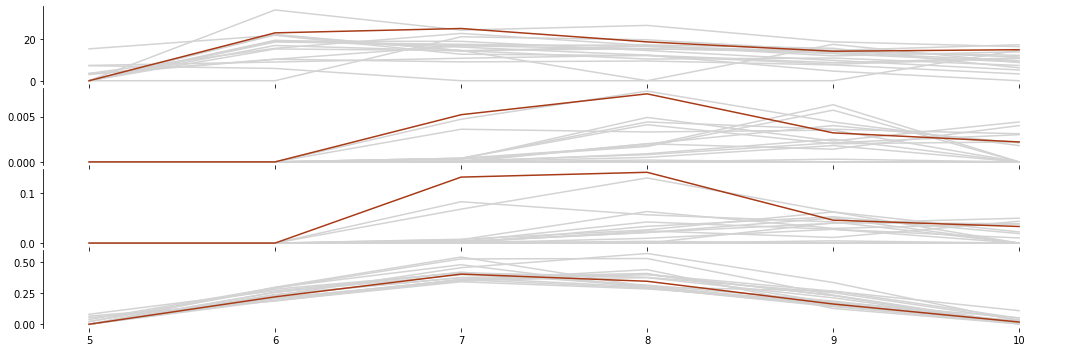

In [22]:
fig, ax = plt.subplots(4,1, figsize=(15,5), sharex=True)

for i,j in enumerate(["abundance", "infection_rate", "vector_index", "index_p"]):

    ax[i].patch.set_alpha(0)
    
    sub_df = df.loc[df["measure"] == j]

    for year in all_years:
        if year == 2019:
            colour="#A83B17"
        else:
            colour="lightgrey"

        ax[i].plot(months, sub_df[year], color=colour)
        
#     ax[i].yaxis.set_visible(False)

    for side in ['top', 'right', 'bottom']:
        ax[i].spines[side].set_visible(False)

overlap=0
h_pad = 5 + (- 5*(1 + overlap))
fig.tight_layout(h_pad=h_pad)



## Pertubans

In [7]:
coq = defaultdict(list)
culiseta = defaultdict(list)

mosquito_detail_ct = ""

with open(mosquito_detail_ct) as f:
    data = csv.DictReader(f)
    for l in data:
        if l['species'] == "Culiseta melanura":
            culiseta[int(l['week'])].append(float(l['abundance']))
        elif l['species'] == "Coquillettidia perturbans":
            coq[int(l['week'])].append(float(l['abundance']))


In [289]:
df_dict = defaultdict(list)

colours = [hex_codes[0], hex_codes[2]]

for k,v in culiseta.items():
    for i in v:
        df_dict['species'].append("Culiseta melanura")
        df_dict['abundance'].append(i)
        df_dict['week'].append(k)
        
for k,v in coq.items():
    for i in v:
        df_dict['species'].append("Coquillettidia pertubans")
        df_dict['abundance'].append(i)
        df_dict['week'].append(k)
        
df = pd.DataFrame(df_dict)
    

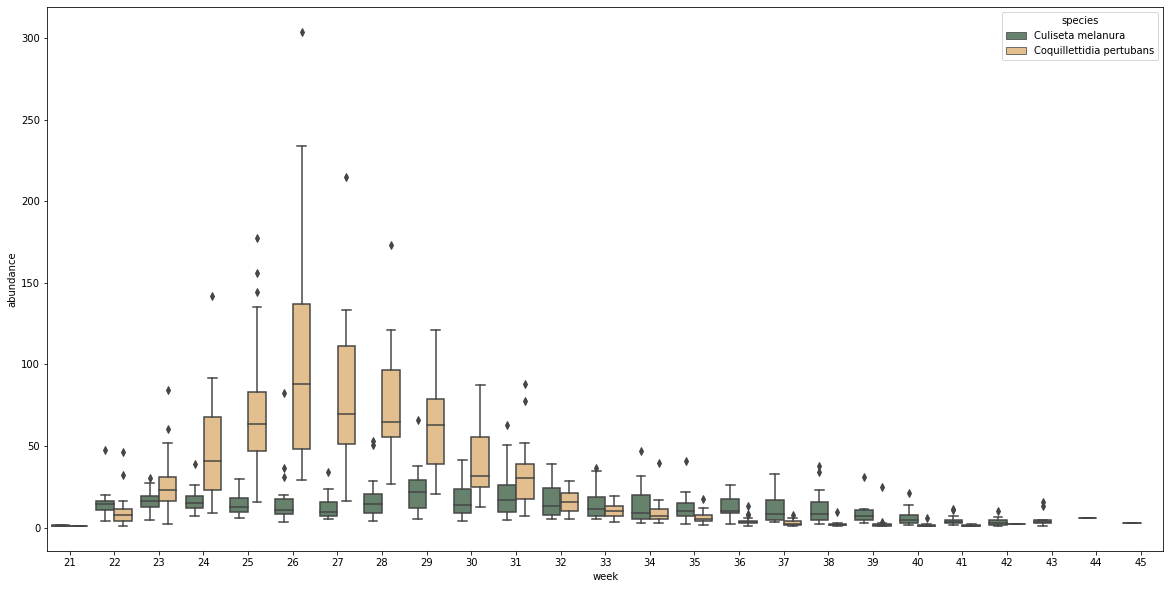

In [293]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

sns.boxplot(x="week", y="abundance",data=df, hue="species", palette=colours)



In [24]:
count = 0
sp_2019 = []
species = []

ct_mosquito_data = ""

with open(ct_mosquito_data) as f:
    data = csv.DictReader(f)
    for l in data:
        species.append(l["Species"])
        if "2019" in l['Date']:
            sp_2019.append(l['Species'])
            
species_count = Counter(species)
# for k,v in species_count.items():
#     print(k,v)
sp_2019_count = Counter(sp_2019)
for k,v in sp_2019_count.items():
    print(k,v)

Culiseta melanura 80
Coquillettidia perturbans 6
Anopheles punctipennis 3
Culex salinarius 4
Culex restuans 2
Ochlerotatus canadensis 5
Culex pipiens 1
Aedes vexans 4
Anopheles quadrimaculatus 1
Psorophora ferox 4
Uranotaenia sapphirina 7
Aedes cinereus 2
Anopheles walkeri 1
Anopheles crucians 1
Ochlerotatus japonicus 1


In [25]:
print(len(sp_2019))

122


In [26]:
ordered = {k:v for k,v in sorted(sp_2019_count.items(), key=lambda x:x[1])}
print(ordered)

{'Culex pipiens': 1, 'Anopheles quadrimaculatus': 1, 'Anopheles walkeri': 1, 'Anopheles crucians': 1, 'Ochlerotatus japonicus': 1, 'Culex restuans': 2, 'Aedes cinereus': 2, 'Anopheles punctipennis': 3, 'Culex salinarius': 4, 'Aedes vexans': 4, 'Psorophora ferox': 4, 'Ochlerotatus canadensis': 5, 'Coquillettidia perturbans': 6, 'Uranotaenia sapphirina': 7, 'Culiseta melanura': 80}


In [21]:
with open(ct_mosquito_data) as f:
    data = csv.DictReader(f)
    for l in data:
        if l['Species'] == "Coquillettidia perturbans" and "2019" in l['Date']:
            print(l)

{'Species': 'Coquillettidia perturbans', 'Site': 'V9', 'Town': 'Voluntown', 'County': 'New London', 'Trap Type': 'Light Trap', 'Date': '2019-08-07', 'CDC Week': '32', 'Accession #': 'V9L-8-7-Cqp', '# Mosquitoes': '31', 'Virus': 'EEE'}
{'Species': 'Coquillettidia perturbans', 'Site': 'HP97', 'Town': 'Hampton', 'County': 'Windham', 'Trap Type': 'Light Trap', 'Date': '2019-08-15', 'CDC Week': '33', 'Accession #': 'HP97L-8-15-Cqp', '# Mosquitoes': '50', 'Virus': 'EEE'}
{'Species': 'Coquillettidia perturbans', 'Site': 'K27', 'Town': 'Killingworth', 'County': 'Middlesex', 'Trap Type': 'Light Trap', 'Date': '2019-08-19', 'CDC Week': '34', 'Accession #': 'K27L-8-19-Cqp', '# Mosquitoes': '11', 'Virus': 'EEE'}
{'Species': 'Coquillettidia perturbans', 'Site': 'HD24', 'Town': 'Haddam', 'County': 'Middlesex', 'Trap Type': 'Light Trap', 'Date': '2019-08-20', 'CDC Week': '34', 'Accession #': 'HD24L-8-20-Cqp-3', '# Mosquitoes': '39', 'Virus': 'EEE'}
{'Species': 'Coquillettidia perturbans', 'Site': 'NS